In [1]:
import pandas as pd
import seaborn as sns
from statsmodels import api as sm
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np

In [2]:
df = pd.read_csv( os.path.join('dataset', 'learning_data_431975.csv'), header=None  )
x = df[ df.columns[ :-1 ] ]
x=pd.DataFrame(x[(x.shape[1]-1)/2])
x.columns=[x.shape[1]-1]
y=  df[ df.columns[ -1 ] ]

df_x=pd.DataFrame()
df_x['original']=x[0]
period=10
df_x['trend']=x[0].rolling(period+1).mean()

point=2
for i in range(1, point+1):
    af_column=f'seasonal_{i}'
    if i == 1:
        df_x[af_column]=x[0].diff(1)
    else:
        bf_column=f'seasonal_{i-1}'
        df_x[af_column]=df_x[bf_column].diff(1)

df_x=df_x[['original', 'trend', af_column]]

df_x['resid']=x[0]-df_x['trend']-df_x[af_column]
df_x['lavel']=y
df=df_x.dropna().reset_index(drop=True)

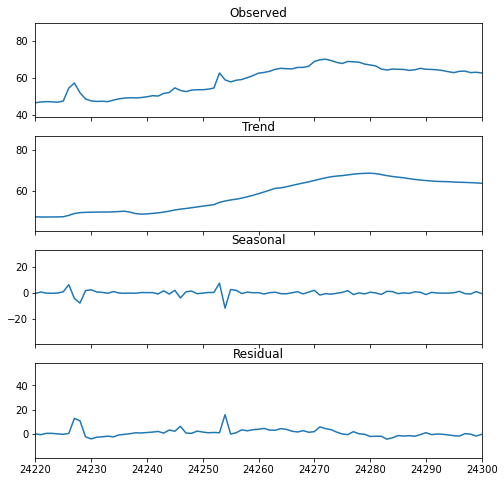

In [3]:
# 描画する領域を用意する
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

# 原系列
axes[0].set_title('Observed')
axes[0].plot(df['original'])

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(df['trend'])

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(df[af_column])

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(df['resid'])

plt.xlim(24220,24300)
# グラフを表示する
plt.show()


In [4]:
# _, axes = plt.subplots(nrows=8, ncols=1, figsize=(16, 32))

# # 原系列
# axes[0].set_title('Observed ACF')
# # 原系列の ACF
# sm.tsa.graphics.plot_acf(x, ax=axes[0])
# # 原系列の PACF
# sm.tsa.graphics.plot_pacf(x, ax=axes[1])

# # 傾向変動
# axes[2].set_title('Trend ACF')
# # 傾向変動の ACF
# sm.tsa.graphics.plot_acf(df['trend'], ax=axes[2])
# # 傾向変動の PACF
# sm.tsa.graphics.plot_pacf(df['trend'], ax=axes[3])

# # 季節変動
# axes[4].set_title('Seasonal ACF')
# sm.tsa.graphics.plot_acf(df[af_column], lags=100, ax=axes[4])
# sm.tsa.graphics.plot_pacf(df[af_column], lags=100, ax=axes[5])

# # 残差 (不規則変動 = 誤差変動 + 特異的変動)
# axes[6].set_title('Residual ACF')
# sm.tsa.graphics.plot_acf(df['resid'], ax=axes[6])
# sm.tsa.graphics.plot_pacf(df['resid'], ax=axes[7])

# # グラフを表示する
# plt.show()

In [5]:
def make_data(x, str):
    x=pd.DataFrame(x)
    window=10
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    
#     for i in range(-1, -window, -1):
#         column=f'{str}_lag{i}'
#         x[column]=x[str].shift(i)   
    return x

lag=[]

# for str in ['original', af_column, 'trend', 'seasonal', 'resid']:
#     lag.append(make_data(df[str], str))
    
for str in ['original']:
    lag.append(make_data(df[str], str))

# lag.append(df['trend'])
# lag.append(df['seasonal'])
# lag.append(df['resid'])

lag.append(df['lavel'])
df_add_lag=pd.concat(lag, axis=1)
df=df_add_lag.dropna().reset_index(drop=True)
df

,original,original_lag1,original_lag2,original_lag3,original_lag4,original_lag5,original_lag6,original_lag7,original_lag8,original_lag9,lavel
0,54.0,54.3,54.5,54.4,54.7,55.2,55.0,55.0,54.9,54.9,0
1,53.8,54.0,54.3,54.5,54.4,54.7,55.2,55.0,55.0,54.9,0
2,54.0,53.8,54.0,54.3,54.5,54.4,54.7,55.2,55.0,55.0,0
3,53.9,54.0,53.8,54.0,54.3,54.5,54.4,54.7,55.2,55.0,0
4,54.0,53.9,54.0,53.8,54.0,54.3,54.5,54.4,54.7,55.2,0
...,...,...,...,...,...,...,...,...,...,...,...
431951,55.4,55.3,54.8,54.9,54.8,55.3,54.8,54.7,54.5,54.9,0
431952,56.0,55.4,55.3,54.8,54.9,54.8,55.3,54.8,54.7,54.5,0
431953,55.8,56.0,55.4,55.3,54.8,54.9,54.8,55.3,54.8,54.7,0
431954,57.0,55.8,56.0,55.4,55.3,54.8,54.9,54.8,55.3,54.8,0


In [6]:
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import os
import numpy as np
import support 

def under_sampling(x):
    import warnings
    import pandas as pd
    import os
    warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
    df = x
    x_majority=df.loc[df.iloc[:,-1]==0]
    x_minority=df.loc[df.iloc[:,-1]==1]
    from sklearn.cluster import KMeans
    km = KMeans(random_state=1, n_clusters=10)
    km.fit(x_majority.iloc[:, :-1])
    x_majority['Cluster'] = km.predict(x_majority.iloc[:, :-1])
    ratio = x_majority['Cluster'].value_counts() / x_majority.shape[0]
    n_sample_ary = (ratio * x_minority.shape[0]).sort_index().astype('int64')
    df_Xs=[]
    for i, n_sample in enumerate(n_sample_ary):
        #重複を許すか許さないかで変わるのか？
        df_Xs.append(x_majority[x_majority['Cluster']==i].sample(n=n_sample, replace=True))

    df_Xs.append(x_minority)
    x=pd.concat(df_Xs, sort=True)
    x=x.drop('Cluster', axis=1)
    
    return x

def calc_avg(x, y):
    import pandas as pd
    import os
    df_x=pd.DataFrame(x)
    df_y=pd.DataFrame(y)
    df_x_raw=df_x[0]
    raw_df=pd.concat([df_x_raw, df_y], axis=1)
    raw_df.columns=range(raw_df.shape[1])
    df_ex=raw_df.loc[raw_df[1]==0]
    N=len(df_ex)
    Leq=10*np.log10(np.sum(np.power(10, df_ex[0]/10)))-10*np.log10(N)
    return Leq

def calc_avg2(x, y):
    import pandas as pd
    import os
    df_x=pd.DataFrame(x)
    df_y=pd.DataFrame(y)
    df_x_raw=df_x[0]
    raw_df=pd.concat([df_x_raw, df_y], axis=1)
    raw_df.columns=range(raw_df.shape[1])
    df_ex=raw_df
    N=len(df_ex)
    Leq=10*np.log10(np.sum(np.power(10, df_ex[0]/10)))-10*np.log10(N)
    return Leq

In [7]:
x = df[ df.columns[ :-1 ] ]
y=  df[ df.columns[ -1 ] ]
# 層化抽出
# kf=StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
kf = KFold( n_splits=3, shuffle=True, random_state=1 )
pr=[]
re=[]
f1 = []
ac = []
y_Leq=[]
pred_Leq=[]
no_Leq=[]
n = []

for train_index, test_index in kf.split(x):
    x_train, x_test = x.loc[train_index, :].values, x.loc[test_index, :].values
    y_train, y_test = y.loc[train_index].values, y.loc[test_index].values
    
    print('train:', len(x_train))
    print('test:', len(x_test))

    # 学習データだけダウンサンプリング
    y_data=y_train[:, np.newaxis]
    data=np.concatenate([x_train, y_data], 1)
    train_df=pd.DataFrame(data)
    train_us=under_sampling(train_df)
    index = train_us.index.tolist()
    x_train=x_train[index]
    y_train=y_train[index]

    rcf = RandomForestClassifier(n_estimators=10, max_depth=5, max_features='sqrt', random_state=1234)
    rcf.fit(x_train, y_train)
    z= rcf.predict(x_test)
    pr.append( precision_score( y_test, z ) )
    re.append( recall_score( y_test, z) )
    f1.append( f1_score( y_test, z ) )
    ac.append( accuracy_score( y_test, z ) )
    n.append( len( x_test ) / len( x ) )

    #等価騒音レベル計算
    no_Leq.append(calc_avg2(x_test, y_test))
    y_Leq.append(calc_avg(x_test, y_test))
    pred_Leq.append(calc_avg(x_test, z))
    
print( 'CV Score:' )
print( '  Precision Score = %f'%( np.average( pr, weights=n ) ) )
print( '  Recall Score = %f'%( np.average( re, weights=n ) ) )
print( '  F1 Score = %f'%( np.average( f1, weights=n ) ) )
print( '  Accuracy Score = %f'%( np.average( ac, weights=n ) ) )
print( '  no_Leq = %f'%( np.average( no_Leq, weights=n ) ) )
print( '  y_Leq = %f'%( np.average( y_Leq, weights=n ) ) )
print( '  pred_Leq = %f'%( np.average( pred_Leq, weights=n ) ) )

train: 287970
test: 143986
train: 287971
test: 143985
train: 287971
test: 143985
CV Score:
  Precision Score = 0.018016
  Recall Score = 0.902166
  F1 Score = 0.035324
  Accuracy Score = 0.448851
  no_Leq = 55.975283
  y_Leq = 55.937031
  pred_Leq = 51.646637
